In [150]:
# importamos las librerías que necesitamos

# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
import scipy.stats as stats
from scipy.stats import norm, chi2_contingency, shapiro, poisson, chisquare, expon, kstest

from statsmodels.stats.proportion import proportions_ztest

# Configuración para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.max_columns', None) 

# Gestión de los warnings
import warnings
warnings.filterwarnings("ignore")

# Fase 4: Problema de A/B Testing.

El objetivo de esta fase es determinar si existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados, y si es así, cuál es la magnitud de esa relación. Partiremos de la siguiente hipótesis, "Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa". Para ello deberéis crear una columna nueva en base al nivel de satisfacción en el trabajo para crear dos grupos, las condiciones para crear los grupos son:

- **Grupo A (Control):** Empleados con un nivel de satisfacción en el trabajo igual o superior a 3 en una escala de 1 a 5.

- **Grupo B (Variante):** Empleados con un nivel de satisfacción en el trabajo inferior a 3 en la misma escala.

La **métrica principal** que debes usar es la tasa de rotación de empleados (Attrition) en cada grupo. Recordemos que, en esta columna, "No" indica que el empleado no ha dejado la empresa (sin rotación), mientras que "Yes" indica que el empleado ha dejado la empresa (con rotación).

Por lo tanto, los pasos que deberás seguir en esta fase son:

1. Divide a los empleados en los grupos A y B según los criterios establecidos.

2. Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

3. Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

4. Analiza los resultados.

5. Calcular la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.

In [151]:
# lo primero que hacemos es cargar el dataframe que vamos a usar para esta lección
df = pd.read_csv("df_imputada.csv")
df.head(2)

,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,DateBirth,RemoteWork,PerformanceRating,TotalWorkingYears,MonthlyIncome
0,no,unknown,684.0,6,3,unknown,"162,0",1,female,51.0,3,5,research_director,3,unknown,6462,7,no,13,3,0,5,3.0,20,15,15,1972,yes,3.0,32.595028,19537.0
1,no,unknown,699.0,1,4,life_sciences,"259,0",3,female,65.0,2,5,manager,3,unknown,5678,0,unknown,14,1,1,5,3.0,33,11,9,1971,yes,3.0,34.000000,19999.0


### 1. Divide a los empleados en los grupos A y B según los criterios establecidos.

In [152]:
df["GroupJobSatisfaction"]= df["JobSatisfaction"].apply(lambda x: 'grupo_A' if x >= 3 else 'grupo_B')

df.sample(4)

,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,DateBirth,RemoteWork,PerformanceRating,TotalWorkingYears,MonthlyIncome,GroupJobSatisfaction
159,no,travel_frequently,1050.0,11,4,medical,"1520,0",2,male,87.0,3,4,manager,4,unknown,24456,3,no,20,1,1,2,3.0,14,1,12,1969,yes,3.139659,26.000000,15701.8,grupo_A
1261,yes,travel_rarely,556.0,23,2,unknown,unknown,2,female,50.0,2,2,manufacturing_director,3,unknown,15497,3,yes,13,1,0,1,3.0,1,0,1,1988,true,3.000000,8.000000,4687.8,grupo_A
659,no,unknown,930.0,3,3,life_sciences,unknown,3,female,57.0,2,2,sales_executive,2,divorced,12227,2,unknown,11,3,1,5,3.0,5,0,4,1982,false,3.000000,14.000000,8938.0,grupo_B
1352,no,unknown,287.0,5,2,unknown,"1012,0",2,female,73.0,3,1,research_scientist,4,unknown,13493,1,no,15,4,0,2,3.0,0,0,0,2005,true,3.000000,11.557874,2849.8,grupo_A


### 2. Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

In [153]:
# Calculamos la Tasa de Rotación

# Dividir los empleados en los grupos A y B
df_grupo_a = df[df['GroupJobSatisfaction'] == "grupo_A"]
df_grupo_b = df[df['GroupJobSatisfaction'] == "grupo_B"]

# Calcular la tasa de rotación en cada grupo (empleados que dejaron la empresa)
tasa_rotacion_a = df_grupo_a['Attrition'].value_counts(normalize=True)['yes']
tasa_rotacion_b = df_grupo_b['Attrition'].value_counts(normalize=True)['yes']
# Empleamos normalize=True para obtener directamente la tasa en términos porcentuales

print(f"Tasa de rotación para el Grupo A: {tasa_rotacion_a:.2%}")
print(f"Tasa de rotación para el Grupo B: {tasa_rotacion_b:.2%}")

Tasa de rotación para el Grupo A: 13.67%
Tasa de rotación para el Grupo B: 19.87%


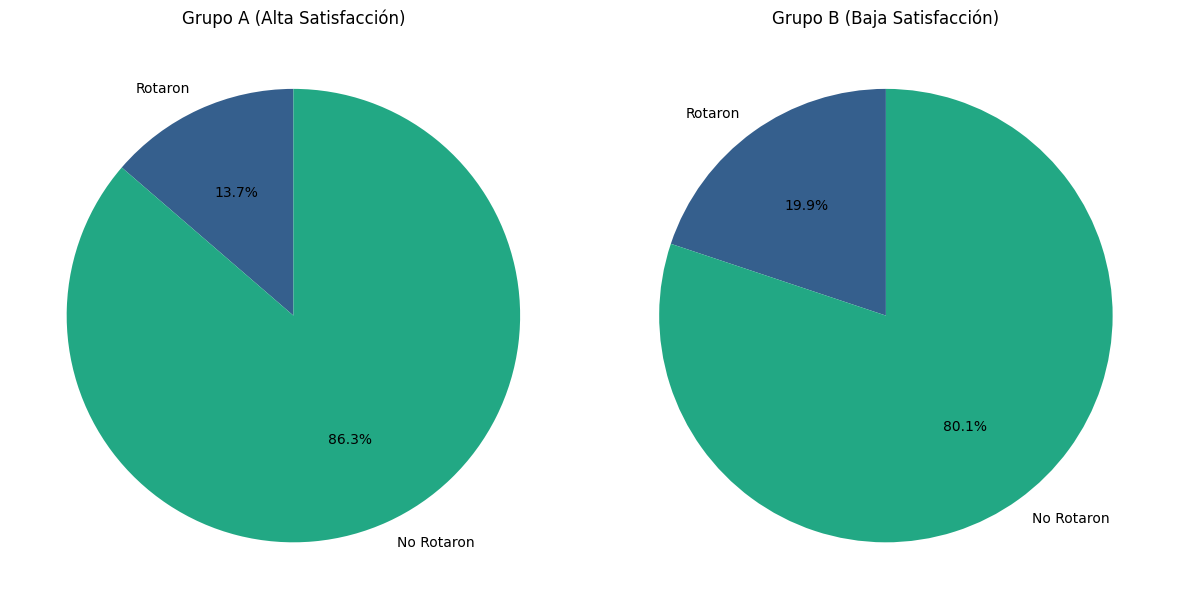

In [179]:
# Calcular la tasa de no rotacion (empleados que no dejaron la empresa)
tasa_no_rotacion_a = df_grupo_a['Attrition'].value_counts(normalize=True)['no']
tasa_no_rotacion_b = df_grupo_b['Attrition'].value_counts(normalize=True)['no']

# Configurar los datos para los gráficos
labels_a = ['Rotaron', 'No Rotaron']
sizes_a = [tasa_rotacion_a*100, tasa_no_rotacion_a*100]
labels_b = ['Rotaron', 'No Rotaron']
sizes_b = [tasa_rotacion_b*100, tasa_no_rotacion_b*100]

# Configurar la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Definir colores de manera explícita desde la paleta viridis
colors_a = plt.cm.viridis([0.3, 0.6]) 
colors_b = plt.cm.viridis([0.3, 0.6]) 

# Gráfico pie para el Grupo A
ax1.pie(sizes_a,
        labels=labels_a,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_a)
ax1.set_title('Grupo A (Alta Satisfacción)')

# Gráfico pie para el Grupo B
ax2.pie(sizes_b,
        labels=labels_b,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_b)
ax2.set_title('Grupo B (Baja Satisfacción)')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

### 3. Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

- **Hipótesis Nula (H0)**: No hay asociación significativa entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Es decir, no hay diferencia en las tasas de rotación entre los diferentes grupos de satisfacción laboral.

- **Hipótesis Alternativa (H1)**: Sí existe una asociación significativa entre el nivel de satisfacción en el trabajo y la rotación de empleados. En términos prácticos, esto podría interpretarse como que hay diferencias significativas en las tasas de rotación entre al menos dos grupos de satisfacción laboral.

#### Prueba chi-cuadrado de proporciones

Dado que estamos comparando proporciones (porcentaje de empleados que dejaron la empresa) entre dos grupos independientes, una prueba chi-cuadrado de independencia puede ser apropiada. Es adecuada para datos categóricos, como en este caso donde estamos comparando la proporción de rotación ("Yes" vs "No") entre dos grupos. El resultado de la prueba de chi-cuadrado y su interpretación ayudarán a determinar si se puede rechazar la hipótesis nula en favor de la alternativa, o si no hay suficiente evidencia para hacerlo.

**Interpretación:**

- Si `p_value < 0.05`: Rechazamos la hipótesis nula. Hay evidencia suficiente para decir que hay una diferencia significativa entre las dos muestras.

- Si `p_value >= 0.05`: No hay evidencia suficiente para rechazar la hipótesis nula. No podemos afirmar que haya una diferencia significativa entre las dos muestras.

,Grupo,% Rotacion,% No Rotacion
0,Alta satisfaccion,13.668342,86.331658
1,Baja satisfaccion,19.870759,80.129241


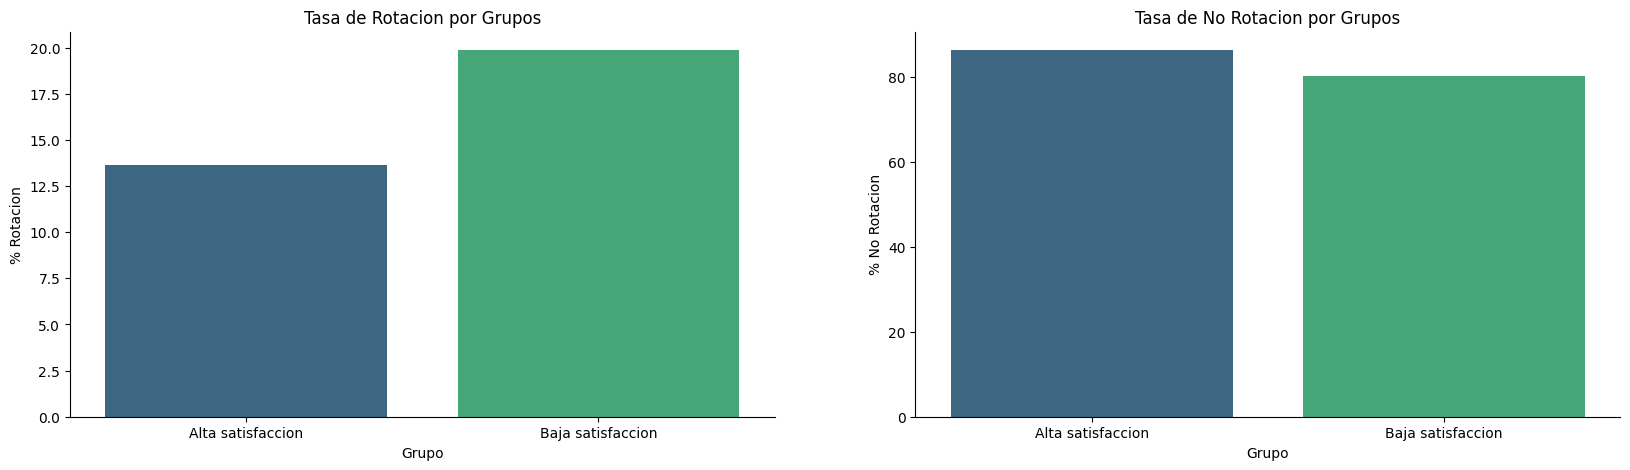

In [172]:
# Hacer un análisis visual previo
data_v = {
    'Grupo': ["Alta satisfaccion", "Baja satisfaccion"],
    '% Rotacion': [tasa_rotacion_a*100, tasa_rotacion_b*100],
    '% No Rotacion': [tasa_no_rotacion_a*100, tasa_no_rotacion_b*100]
}

df_v = pd.DataFrame(data_v)
display(df_v.head())

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x="Grupo", y="% Rotacion", data=df_v,  palette = "viridis", ax = axes[0])
sns.barplot(x="Grupo", y="% No Rotacion", data=df_v,  palette = "viridis", ax = axes[1])

axes[0].set_title("Tasa de Rotacion por Grupos")
axes[1].set_title("Tasa de No Rotacion por Grupos")
# Quitar la linea de arriba y de la derecha
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

In [157]:
# Crear una tabla de contingencia
contingency_table = pd.crosstab(df['GroupJobSatisfaction'], df['Attrition'])
display(contingency_table)

# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"\nChi-cuadrado: {chi2}")
print(f"p-valor: {p_value}")

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print("\nHay una diferencia significativa en las tasas de rotacion entre el Grupo de A (de control) y el Grupo B (de prueba).")
    print("Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas.")
else:
    print("\nNo hay evidencia de una diferencia significativa en las tasas de rotación entre los grupos.")
    print("Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas.")

Attrition,no,yes
GroupJobSatisfaction,,
grupo_A,859,136
grupo_B,496,123



Chi-cuadrado: 10.441300351335348
p-valor: 0.0012322848438575645

Hay una diferencia significativa en las tasas de rotacion entre el Grupo de A (de control) y el Grupo B (de prueba).
Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas.


### 4. Analiza los resultados.

El p-valor es menor que el nivel de significancia (α = 0.05), entonces rechazamos la hipótesis nula (H0) en favor de la alternativa (H1). Esto significa que hay suficiente evidencia para sugerir que existe una relación significativa entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.

### 5. Calcular la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.

En este caso, la diferencia de medias se interpreta como la diferencia de las tasas de rotación promedio (que son proporciones) entre los grupos A y B.

In [181]:
# Calcular la diferencia de proporciones entre los grupos A y B
diferencia_proporciones = tasa_rotacion_b - tasa_rotacion_a

print(f"Diferencia de proporciones (tasa de rotación) entre Grupo B y Grupo A: {diferencia_proporciones:.2%}")

Diferencia de proporciones (tasa de rotación) entre Grupo B y Grupo A: 6.20%


**Conclusiones**

Como estamos evaluando el impacto del nivel de satisfaccion en el trabajo en la rotación de empleados, una diferencia del 6.20% podría ser considerada significativa. La tasa de rotación del Grupo B es más alta que la del Grupo A, y nos indica q ue los empleados con baja satisfacción tienen una propabilidad relativamente mayor de dejar la empresa en comparación con aquellos con alta satisfacción.

Habría que mejorar el nivel de satisfacción laboral para una mejor retención de empleados y así reducir la tasa de rotación. Por ejemplo, mejoras en el entorno de trabajo, incentivos económicos, a través de políticas de recursos humanos, etc.

El factor temporal es también algo estratégico, se puede proponer monitorear estas métricas a lo largo del tiempo para evaluar el impacto de las decisiones estratégicas.
